# Image classification using Logistic regression on BUSI dataset

Here, we experiment with Logistic Regression where the following features are used:
 1. Raw pixels
 2. Gaussian filter
 3. Sobel filter
 4. PCA components

 We use Gridsearch to tune the models.

### Import packages

In [1]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Functions to assess model quality and to plot confusion matrix, ROC etc.

In [2]:
# Plot confusion matrix (binary)
def plot_cm(cm):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.title("Confusion matrix")
    plt.show()
    

# Plot ROC
def plot_ROC(fpr, tpr, auc):

    plt.figure(figsize = (6.4, 6.4))
    plt.plot(fpr, tpr, label= f"ROC, auc= {auc:.2f}")
    plt.title("ROC curve")
    plt.legend(loc=4)
    plt.show()
    

# To assess model quality analysis
def model_quality(model, X_train, X_test, y_train, y_test):

    # Accuracy
    print(f"Model accuracy on training data: {model.score(X_train, y_train):.2f} ")
    print(f"Model accuracy on test data: {model.score(X_test, y_test):.2f} ")

    # Classification report (precision, recall, f1 score)
    print(f"\nClassification report:\n {classification_report(y_test, model.predict(X_test))} ")

    # Confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print(f"Confusion matrix:\n {cm}\n")
    plot_cm(cm)

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plot_ROC(fpr, tpr, auc)

# Get indices for True positives, True negatives, False positives and False negatives
def get_indices(model, X, y):

    y_pred = model.predict(X)
    tp_index = np.argwhere( (y == 1) & (y_pred == 1))
    tn_index = np.argwhere( (y == 0) & (y_pred == 0))
    fp_index = np.argwhere( (y == 0) & (y_pred == 1))
    fn_index = np.argwhere( (y == 1) & (y_pred == 0))

    return (tp_index, tn_index, fp_index, fn_index)

## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [3]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of all images in a image directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Prepare data for classification
 - Generate feature (pixels) and target data (0 for benign and 1 for malignant)
 - Shuffle the data
 - Split data in to training and test (70-30) set
 - Scale the data (use Standard scaler)

In [4]:
# Assemble feature and target data
img_data = np.empty((0, img_res*img_res), np.float32)

# Read and append images to img_data
#img_list = malignant_img_list_all[0:3:2]
img_list = benign_img_list_all + malignant_img_list_all
img_data = append_img_data(img_list, img_data)
print_ndarray_info(img_data, "Image feature data - benign + malignant")

# Create labels - 0 for benign and 1 for malignant
img_labels = np.array([0]*num_benign_img, dtype= np.int32)
img_labels = np.append(img_labels, np.array([1]*num_malignant_img, dtype= np.int32))

# Indices are used to recover images after shuffling
# indices 0 to num_benign_img - 1 is from benign and rest for malignant
indices = np.arange(0, num_benign_img + num_malignant_img, dtype= np.int32)

X, y = img_data, img_labels

print(img_data.shape)
print(img_labels.shape)

Image feature data - benign + malignant [ndim, shape, dtype, min, max]: [2, (857, 65536), float32, 0.0, 1.0]
(857, 65536)
(857,)


### Shuffle, split and scale the dataset

In [5]:
# Shuffle and split data (keep same proportions of positive and negative in training and test set)
X_train_orig, X_test_orig, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.3, random_state= 7, stratify= y)
print_ndarray_info(X_train_orig, "X_train: ")
print_ndarray_info(X_test_orig, "X_test: ")

# Scale training data and transform the test data
scaler = StandardScaler()
X_train_orig = scaler.fit_transform(X_train_orig)
X_test_orig = scaler.transform(X_test_orig)

X_train:  [ndim, shape, dtype, min, max]: [2, (599, 65536), float32, 0.0, 1.0]
X_test:  [ndim, shape, dtype, min, max]: [2, (258, 65536), float32, 0.0, 1.0]


### 1. Logistic regression with raw pixels:
#### C = 1.0 (Inverse of regularization strength)

In [6]:
# Create a model and train
# solver= 'liblinear' 'lbfgs'
model = LogisticRegression(solver= 'liblinear', C= 1.0, random_state= 0)
X_train, X_test = X_train_orig.copy(), X_test_orig.copy()
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

### Assess model quality

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.75 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       132
           1       0.73      0.78      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[95 37]
 [28 98]]



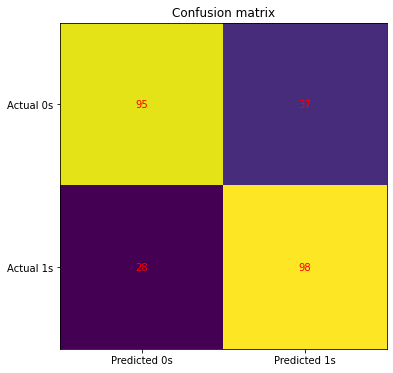

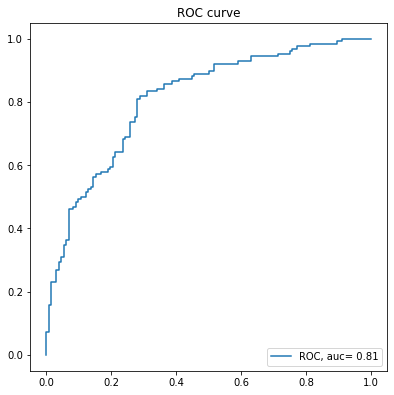

In [7]:
model_quality(model, X_train, X_test, y_train, y_test)

### 1. Logistic regression with raw pixels: 
 - Fine tune logistic regression model using Gridsearch

In [8]:
# Define parameter range 
# 'solver': ['liblinear', 'lbfgs', 'newton-cg']
param_grid = {'penalty':  ['l1', 'l2'],
              'C': [0.01, 0.1, 1.0, 10.0],  
              'solver': ['liblinear']
             }

grid = GridSearchCV(LogisticRegression(random_state= 0), param_grid, scoring= 'accuracy', refit= True, verbose= 3)

# Fit the model using grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.625 total time=   1.5s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.608 total time=   1.6s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.508 total time=   1.2s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.642 total time=   1.3s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.689 total time=   1.3s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.792 total time=  15.7s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.708 total time=  16.7s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.783 total time=  17.7s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.725 total time=  18.7s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.790 total time=  16.8s
[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.808 total time=   2.4s
[CV 2/5] END C=0.1, penalty=

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

### 1. Logistic regression with raw pixels: 
 - Assess the quality of the best model produced by Gridsearch

Best model parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model accuracy on training data: 0.94 
Model accuracy on test data: 0.77 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77       132
           1       0.77      0.75      0.76       126

    accuracy                           0.77       258
   macro avg       0.77      0.77      0.77       258
weighted avg       0.77      0.77      0.77       258
 
Confusion matrix:
 [[103  29]
 [ 31  95]]



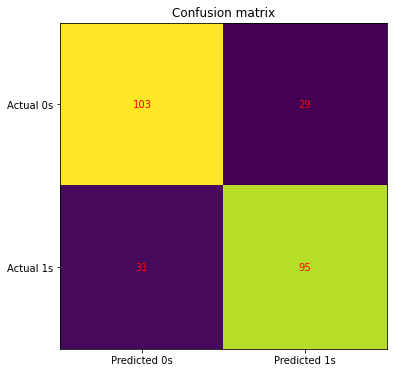

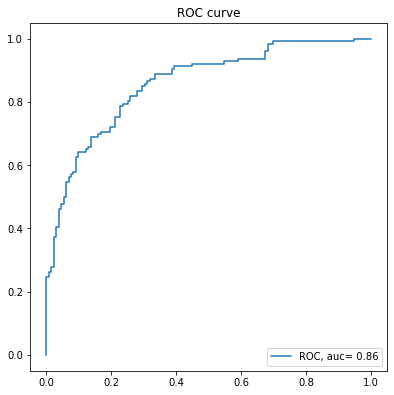

In [9]:
# Print best parameter after tuning 
print("Best model parameters: ", grid.best_params_)
model_best = grid.best_estimator_
# Assess model quality
model_quality(model_best, X_train, X_test, y_train, y_test)

### 2. Logistic regression with Gaussian filter

In [10]:
# Apply Gaussian filter to X_train and X_test
X_train, X_test = X_train_orig.copy(), X_test_orig.copy()

nsamples, nfeatures = X_train.shape
for isample in range(0, nsamples):
    img = X_train[isample,:].reshape((img_res, img_res))
    X_train[isample,:] = cv2.GaussianBlur(img, (5,5), 0).reshape((1, -1))

nsamples, nfeatures = X_test.shape
for isample in range(0, nsamples):
    img = X_test[isample,:].reshape((img_res, img_res))
    X_test[isample,:] = cv2.GaussianBlur(img, (5,5), 0).reshape((1, -1))

### 2. Logistic regression with Gaussian filter
 - Fine tune Logistic regression with Gaussian filter using Gridsearch

In [11]:
# Define parameter range 
# 'solver': ['liblinear', 'lbfgs', 'newton-cg']
param_grid = {'penalty':  ['l1', 'l2'],
              'C': [0.01, 0.1, 1.0, 10.0],  
              'solver': ['liblinear']
             }

grid = GridSearchCV(LogisticRegression(random_state= 0), param_grid, scoring= 'accuracy', refit= True, verbose= 3)

# Fit the model using grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.508 total time=   1.6s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.633 total time=   1.6s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.508 total time=   1.7s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.508 total time=   2.1s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.513 total time=   2.1s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.783 total time=  21.2s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.717 total time=  20.9s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.783 total time=  19.4s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.708 total time=  19.5s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.782 total time=  20.2s
[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.800 total time=   2.3s
[CV 2/5] END C=0.1, penalty=

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

### 2. Logistic regression with Gaussian filter
 - Assess the quality of the best model produced by Gridsearch

Best model parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model accuracy on training data: 0.90 
Model accuracy on test data: 0.76 

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77       132
           1       0.76      0.75      0.75       126

    accuracy                           0.76       258
   macro avg       0.76      0.76      0.76       258
weighted avg       0.76      0.76      0.76       258
 
Confusion matrix:
 [[102  30]
 [ 32  94]]



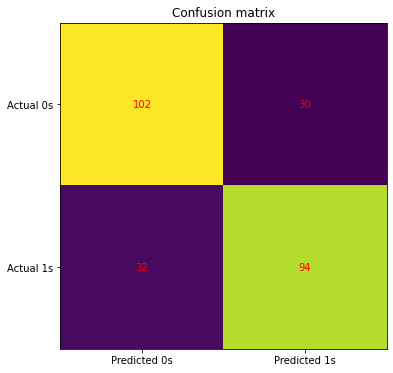

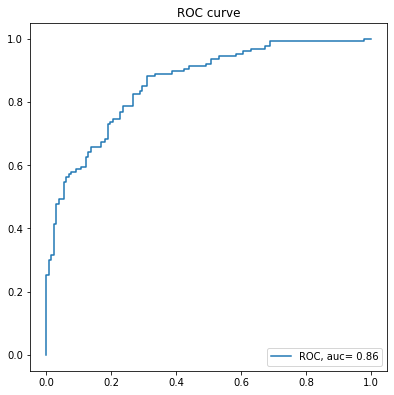

In [12]:
# Print best parameter after tuning 
print("Best model parameters: ", grid.best_params_)
model_best = grid.best_estimator_
# Assess model quality
model_quality(model_best, X_train, X_test, y_train, y_test)

### 3. Logistic regression with Sobel filter

In [13]:
# Apply Sobel filter to X_train and X_test
X_train, X_test = X_train_orig.copy(), X_test_orig.copy()

nsamples, nfeatures = X_train.shape
for isample in range(0, nsamples):
    img = X_train[isample,:].reshape((img_res, img_res))
    X_train[isample,:] = cv2.Sobel(img, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5).reshape((1, -1))

nsamples, nfeatures = X_test.shape
for isample in range(0, nsamples):
    img = X_test[isample,:].reshape((img_res, img_res))
    X_test[isample,:] = cv2.Sobel(img, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5).reshape((1, -1))

### 3. Logistic regression with Sobel filter
 - Fine tune Logistic regression with Sobel filter using Gridsearch

In [14]:
# Define parameter range ['liblinear', 'lbfgs', 'newton-cg']
param_grid = {'penalty':  ['l1', 'l2'],
              'C': [0.01, 0.1, 1.0, 10.0],  
              'solver': ['liblinear']
             }

grid = GridSearchCV(LogisticRegression(random_state= 0), param_grid, scoring= 'accuracy', refit= True, verbose= 3)

# Fit the model using grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.683 total time=   2.4s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.683 total time=   1.9s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.583 total time=   2.6s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.617 total time=   2.4s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.672 total time=   2.1s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.725 total time=  11.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.742 total time=  10.3s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.600 total time=  10.5s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.617 total time=  10.7s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.748 total time=  11.2s
[CV 1/5] END C=0.1, penalty=l1, solver=liblinear;, score=0.692 total time=   2.0s
[CV 2/5] END C=0.1, penalty=

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

### 3. Logistic regression with Sobel filter
 - Assess the quality of the best model produced by Gridsearch

Best model parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Model accuracy on training data: 1.00 
Model accuracy on test data: 0.64 

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.59      0.63       132
           1       0.62      0.69      0.65       126

    accuracy                           0.64       258
   macro avg       0.64      0.64      0.64       258
weighted avg       0.64      0.64      0.64       258
 
Confusion matrix:
 [[78 54]
 [39 87]]



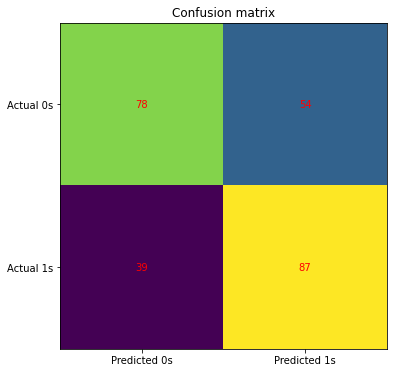

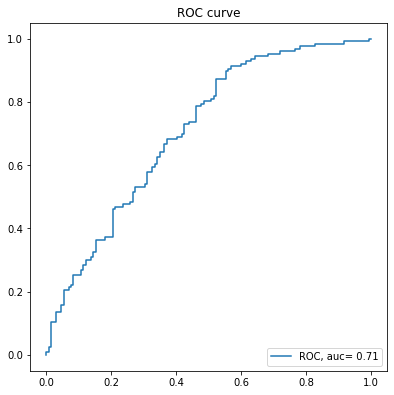

In [15]:
# Print best parameter after tuning 
print("Best model parameters: ", grid.best_params_)
model_best = grid.best_estimator_
# Assess model quality
model_quality(model_best, X_train, X_test, y_train, y_test)

### 4. Logistic regression with PCA components as features

In [16]:
# Apply PCA fit and transformation to X_train and PCA transform to X_test
X_train, X_test = X_train_orig.copy(), X_test_orig.copy()

pca = PCA(.90)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### 4. Logistic regression with PCA components as features
 - Fine tune Logistic regression with PCA components as features using Gridsearch

In [17]:
# Define parameter range ['liblinear', 'lbfgs', 'newton-cg']
param_grid = {'penalty':  ['l1', 'l2'],
              'C': [0.001, .005, 0.01, 0.05, 0.1, 1.0],  
              'solver': ['liblinear']
             }

grid = GridSearchCV(LogisticRegression(random_state= 0), param_grid, scoring= 'accuracy', refit= True, verbose= 3)

# Fit the model using grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.742 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.725 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.667 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.675 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.731 total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.775 total time=   0.0s
[CV 2/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.692 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.708 total time=   0.0s
[CV 4/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.733 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.765 total time=   0.0s
[CV 1/5] END C=0.005, penalty=l1, solver=liblinear;, score=0.783 total time=   0.0s
[CV 2/5] END C=

GridSearchCV(estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=3)

### 4. Logistic regression with PCA components as features
 - Assess the quality of the best model produced by Gridsearch

Best model parameters:  {'C': 0.005, 'penalty': 'l1', 'solver': 'liblinear'}
Model accuracy on training data: 0.80 
Model accuracy on test data: 0.73 

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.73      0.74       132
           1       0.72      0.74      0.73       126

    accuracy                           0.73       258
   macro avg       0.73      0.73      0.73       258
weighted avg       0.73      0.73      0.73       258
 
Confusion matrix:
 [[96 36]
 [33 93]]



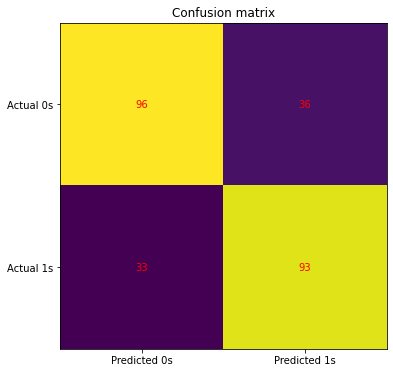

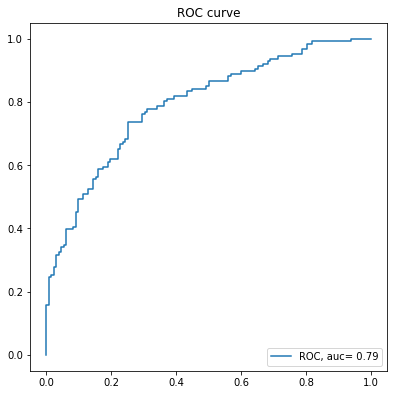

In [18]:
# Print best parameter after tuning 
print("Best model parameters: ", grid.best_params_)
model_best = grid.best_estimator_
# Assess model quality
model_quality(model_best, X_train, X_test, y_train, y_test)